#### 1. Import the necessary libraries

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
import random

import cv2
import pickle
from keras import backend as k
import tensorflow as tf
from tensorflow.keras import models, layers
import seaborn as sns

# 1. CNN Architecture:

### 1.1 List the categories of the data and plot the distribution of images across the classes

In [2]:
img_categories = ['control', 'ms', 'myelitis']

In [3]:
dir_path = 'C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\control'
file_names_control = os.listdir(dir_path)
category = os.path.basename(os.path.dirname(dir_path))
for file in file_names_control:
        img_categories.append(category)      

In [4]:
dir_path = 'C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\ms'
file_names_ms = os.listdir(dir_path)
category = os.path.basename(os.path.dirname(dir_path))
for file in file_names_ms:
      img_categories.append(category)  

In [5]:
dir_path = 'C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\myelitis'
file_names_myelitis = os.listdir(dir_path)
category = os.path.basename(os.path.dirname(dir_path))
for file in file_names_myelitis:
      img_categories.append(category)  

In [6]:
img_categories = []
def get_categories(dir_path):
    filenames = os.listdir(dir_path)
    # Directly extract the category name from the dir_path
    category = os.path.basename(dir_path)  # Change made here
    for file in filenames:
        img_categories.append(category)
    
    return filenames


In [7]:
img_categories = []
file_names_control = get_categories('C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\control')
file_names_ms   = get_categories('C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\ms')
file_names_myelitis   = get_categories('C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\myelitis')

In [8]:
len(img_categories)

2470

In [9]:
all_file_names = file_names_control + file_names_ms + file_names_myelitis

In [10]:
len(all_file_names)

2470

In [11]:
df = pd.DataFrame({'Image': all_file_names, 'Infection_Type': img_categories})
df

,Image,Infection_Type
0,3 (1).jpg,control
1,3 (10).png,control
2,3 (100).jpg,control
3,3 (101).jpg,control
4,3 (102).jpg,control
...,...,...
2465,1 (95).jpg,myelitis
2466,1 (96).jpg,myelitis
2467,1 (97).jpg,myelitis
2468,1 (98).jpg,myelitis


<Axes: xlabel='Infection_Type', ylabel='count'>

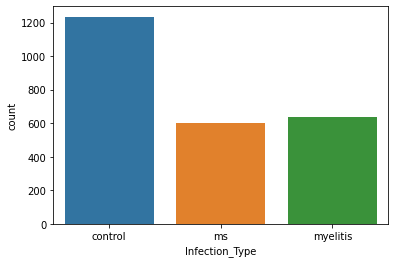

In [12]:
sns.countplot(x='Infection_Type',data=df)

### 1.3 Plotting the sample images for all the classes

In [13]:
def show_sample_images(dir_path):
    filenames = os.listdir(dir_path)
    sample = random.choice(filenames)
    # Directly extract the category name from the dir_path for the infection type
    infection_type = os.path.basename(dir_path)  # Change made here
    print('Infection Type: ', infection_type)
    print('Image name:     ', sample)
    img_array = cv2.imread(os.path.join(dir_path, sample), cv2.IMREAD_GRAYSCALE)  # Improved path handling
    print('Image shape:    ', img_array.shape)
    image = load_img(os.path.join(dir_path, sample))  # Improved path handling
    plt.imshow(image)
    plt.show()  # Ensure the image is displayed
    return


Infection Type:  control
Image name:      33 (1457).png
Image shape:     (569, 1158)


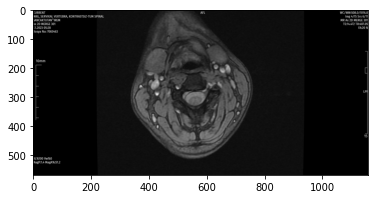

In [14]:
show_sample_images('C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\control')

Infection Type:  ms
Image name:      2 (678).jpg
Image shape:     (701, 701)


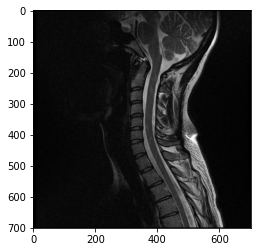

In [15]:
show_sample_images('C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\ms')

Infection Type:  myelitis
Image name:      1 (188).jpg
Image shape:     (706, 706)


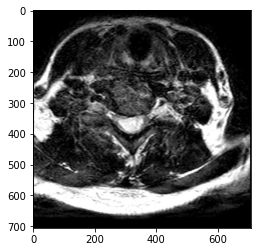

In [16]:
show_sample_images('C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\myelitis')

### 1.3 Building Data Augmentation for Training
First I am using color mode as rgb to test the model on 3 channel images. Then I will change it to gray scale. 

In [17]:
train_cnn_gen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,     # Randomly Zoom by 20% some training images
                             rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
                             horizontal_flip = True) # Randomly flip images horizontally.

In [18]:
test_cnn_gen = ImageDataGenerator(rescale= 1./255)

In [19]:
# Once our model is ready, we directly read the data from train folder and augment the data.
train_cnn_data_generator = train_cnn_gen.flow_from_directory('C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train',
                                           target_size = (48, 48),
                                           batch_size = 32,     
                                           color_mode = 'rgb',
                                           #color_mode = 'grayscale',                  
                                           class_mode = 'categorical',
                                           shuffle=True                                           
                                          )


Found 2470 images belonging to 3 classes.


In [20]:
# Once our model is ready, we directly read the data from test folder and augment the data.
test_cnn_data_generator = test_cnn_gen.flow_from_directory('C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\test',                                                 
                                                 target_size=(48,48),
                                                 batch_size= 32,
                                                 color_mode = 'rgb',
                                                 #color_mode = 'grayscale',
                                                 class_mode= 'categorical'                                               
                                                )

Found 276 images belonging to 3 classes.


In [21]:
nb_train_samples = len(train_cnn_data_generator.filenames) 
num_classes = len(train_cnn_data_generator.class_indices) 

# get the class labels for the training data, in the original order 
train_labels = train_cnn_data_generator.classes 

print(nb_train_samples)
print(num_classes)
print(train_labels)

2470
3
[0 0 0 ... 2 2 2]


In [22]:
train_cnn_data_generator[0][0].shape

(32, 48, 48, 3)

In [23]:
train_cnn_data_generator[0][0][0].shape

(48, 48, 3)

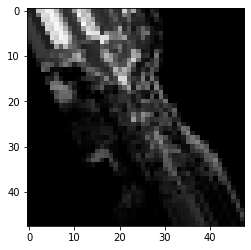

In [24]:
plt.imshow(train_cnn_data_generator[0][0][0])
plt.show()

In [25]:
nb_test_samples = len(test_cnn_data_generator.filenames) 
num_test_classes = len(test_cnn_data_generator.class_indices) 


#get class labels for the training data, in the original order 
test_labels = test_cnn_data_generator.classes 
print(nb_test_samples)
print(num_test_classes)
print(test_labels)

276
3
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [26]:
cnn_model = Sequential()
cnn_model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (48,48,3)))
#cnn_model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (48,48,1)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_model.add(Conv2D(34 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
cnn_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn_model.add(Dropout(0.1))
cnn_model.add(BatchNormalization())
cnn_model.add(Flatten())
cnn_model.add(Dense(units = 128 , activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(units = 256 , activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(units = 3 , activation = 'softmax'))

cnn_model.compile(optimizer = "rmsprop" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
cnn_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 34)        4930      
                                                                 
 dropout (Dropout)           (None, 24, 24, 34)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 34)      

### 1.4 Use early stopping with the patience of two epochs and monitor the validation loss or accuracy

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=100,restore_best_weights=True) 

In [28]:
print(train_cnn_data_generator.n)
print(train_cnn_data_generator.batch_size)

2470
32


In [29]:
step_size_train=train_cnn_data_generator.n//train_cnn_data_generator.batch_size
step_size_val=test_cnn_data_generator.n//test_cnn_data_generator.batch_size
print(step_size_train)
print(step_size_val)

77
8


### 1.5 Training the CNN model

In [30]:
# Training the model
epochs = 100
history = cnn_model.fit(    
    train_cnn_data_generator, 
    epochs=epochs,
    validation_data=test_cnn_data_generator,
    validation_steps = step_size_val,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100




78/78 [==============================] - 23s 266ms/step - loss: 0.6594 - accuracy: 0.7320 - val_loss: 1.5511 - val_accuracy: 0.2656
Epoch 2/100
78/78 [==============================] - 19s 245ms/step - loss: 0.5344 - accuracy: 0.7879 - val_loss: 1.9415 - val_accuracy: 0.2539
Epoch 3/100
78/78 [==============================] - 19s 239ms/step - loss: 0.4981 - accuracy: 0.8077 - val_loss: 1.8578 - val_accuracy: 0.3086
Epoch 4/100
78/78 [==============================] - 19s 238ms/step - loss: 0.4677 - accuracy: 0.8166 - val_loss: 1.6030 - val_accuracy: 0.3672
Epoch 5/100
78/78 [==============================] - 19s 240ms/step - loss: 0.4507 - accuracy: 0.8158 - val_loss: 1.1649 - val_accuracy: 0.4922
Epoch 6/100
78/78 [==============================] - 19s 240ms/step - loss: 0.4328 - accuracy: 0.8279 - val_loss: 0.5589 - val_accuracy: 0.7305
Epoch 7/100
78/78 [==============================] - 19s 241ms/step - loss: 0.4384 - accuracy: 0.8271 - val_loss: 0.6063 - val_accuracy: 0.7109
Ep

In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):    
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

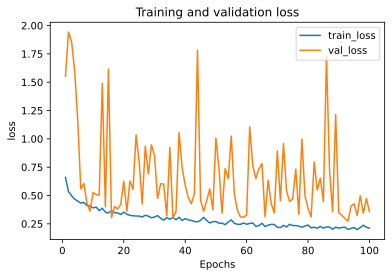

In [32]:
plot_metric(history, 'loss')

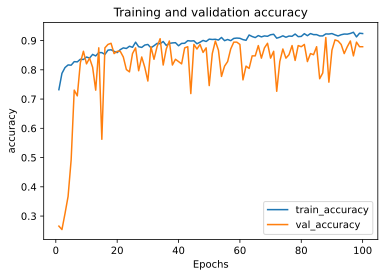

In [33]:
plot_metric(history, 'accuracy')

In [34]:
 # returns accuracy of training
print("Training Accuracy: ", history.history['accuracy'][-1])
print("Testing Accuracy : ", history.history['val_accuracy'][-1])

Training Accuracy:  0.9238866567611694
Testing Accuracy :  0.87890625


In [35]:
score = cnn_model.evaluate(test_cnn_data_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


9/9 [==============================] - 2s 167ms/step - loss: 0.3437 - accuracy: 0.8841
Test loss: 0.34374064207077026
Test accuracy: 0.8840579986572266


In [36]:
# returns accuracy of training
print("Training Accuracy: ", history.history['accuracy'][-1])
print("Testing Accuracy : ", history.history['val_accuracy'][-1])

Training Accuracy:  0.9238866567611694
Testing Accuracy :  0.87890625


In [37]:
predictions = cnn_model.predict(test_cnn_data_generator)
predictions = predictions.reshape(1,-1)[0]
predictions[:10]
y_classes = predictions.argmax(axis=-1)
y_classes

9/9 [==============================] - 2s 161ms/step


820

#### Testing the model

In [38]:
Y_pred = cnn_model.predict(test_cnn_data_generator, test_cnn_data_generator.n//test_cnn_data_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

9/9 [==============================] - 2s 162ms/step


array([1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 2, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 1,
       0, 0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 0, 1, 0, 2, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 2, 2, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 2,
       0, 2, 2, 0, 0, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       2, 0, 1, 1, 0, 2, 0, 1, 0, 0, 1, 1, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2,
       0, 1, 2, 1, 1, 0, 0, 1, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2,
       1, 1, 1, 0, 2, 0, 1, 2, 1, 1, 0, 0, 1, 2, 1, 1, 2, 2, 0, 0, 0, 1,
       1, 0, 0, 0, 2, 1, 2, 1, 2, 0, 1, 1, 1, 0, 2, 0, 1, 0, 2, 0, 0, 1,
       2, 2, 2, 0, 1, 0, 0, 0, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 1, 0, 2, 0,
       1, 0, 1, 0, 0, 1, 2, 1, 1, 0, 1, 0], dtype=int64)

[1. 0. 0.]


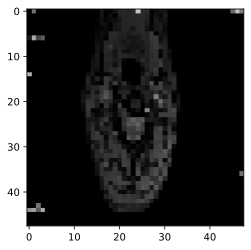

In [39]:
print(test_cnn_data_generator[0][1][0])
plt.imshow(test_cnn_data_generator[0][0][0])
plt.show()

In [40]:
test_image = test_cnn_data_generator[0][0][0].reshape(-1,48,48,3)
test_image.shape

(1, 48, 48, 3)

In [41]:
predictions = cnn_model.predict(test_image)
predictions = predictions.reshape(1,-1)[0]
predictions[:10]
y_classes = predictions.argmax(axis=-1)
y_classes

1/1 [==============================] - 0s 142ms/step


0

In [42]:
y_pred

array([1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 2, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 1,
       0, 0, 0, 1, 2, 1, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 2, 0, 1, 0, 2, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 2, 2, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 2,
       0, 2, 2, 0, 0, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       2, 0, 1, 1, 0, 2, 0, 1, 0, 0, 1, 1, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2,
       0, 1, 2, 1, 1, 0, 0, 1, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2,
       1, 1, 1, 0, 2, 0, 1, 2, 1, 1, 0, 0, 1, 2, 1, 1, 2, 2, 0, 0, 0, 1,
       1, 0, 0, 0, 2, 1, 2, 1, 2, 0, 1, 1, 1, 0, 2, 0, 1, 0, 2, 0, 0, 1,
       2, 2, 2, 0, 1, 0, 0, 0, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 1, 0, 2, 0,
       1, 0, 1, 0, 0, 1, 2, 1, 1, 0, 1, 0], dtype=int64)

control
33 (1335).png


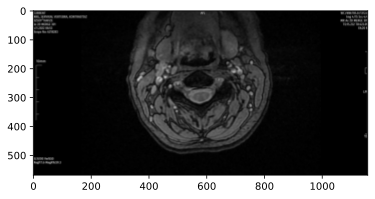

In [43]:
control_path = 'C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\control\\'
filenames = os.listdir(control_path)
sample = random.choice(filenames)
print(os.path.basename(os.path.dirname(control_path)))
print(sample)
image = load_img(control_path + sample)
plt.imshow(image)

img_array = cv2.imread(control_path + sample)

In [44]:
img_array.shape

(569, 1158, 3)

In [45]:
test_img = img_resize_array = cv2.resize(img_array, (48,48))
test_img.shape

(48, 48, 3)

In [46]:
test_img = np.reshape(test_img,(-1,48,48,3))
test_img.shape

(1, 48, 48, 3)

In [47]:
predictions = cnn_model.predict(test_img)
predictions = predictions.reshape(1,-1)[0]
# predictions[:10]
y_classes = predictions.argmax(axis=-1)
y_classes

1/1 [==============================] - 0s 160ms/step


0

#### In this case the Predicted result and Actual Result matches. 
The image is of Healthy type (0) and model predicted correctly to 0.

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(test_cnn_data_generator.classes, y_pred)
target_names = ['control', 'ms', 'myelitis'] #classes names
clf_rpt = classification_report(test_cnn_data_generator.classes, y_pred, target_names=target_names)

In [49]:
target_names = ['control', 'ms', 'myelitis'] #classes names
clf_rpt = classification_report(test_cnn_data_generator.classes, y_pred, target_names=target_names)
print(clf_rpt)

              precision    recall  f1-score   support

     control       0.54      0.54      0.54       138
          ms       0.23      0.28      0.26        67
    myelitis       0.32      0.25      0.28        71

    accuracy                           0.41       276
   macro avg       0.36      0.36      0.36       276
weighted avg       0.41      0.41      0.41       276



End of CNN Architecture


# 2. Transfer learning using mobile net

In [50]:
import tensorflow_hub as hub  # tensorflow_hub is a place that contains all the pre-trained models
from keras.applications.mobilenet_v2 import MobileNetV2

#### 1. Prepare data for the pre-trained mobile net model, with color mode as RGB

All images are having 3 channels that are required for feeding into mobilenetv2. \
Now we need to reshape all the images to 224 x224 size to obtain shape (224 x 224 x 3)

In [51]:
from skimage.color import gray2rgb
from skimage.io import imread, imsave
from skimage.filters import threshold_otsu
from skimage import img_as_uint

inp_image = imread("C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\control\\3 (1).jpg")
inp_image.shape

(705, 705, 3)

In [52]:
# Testing rehsape
from PIL import Image
image = Image.open('C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\control\\3 (55).jpg')
print(f"Original size : {image.size}") 
print(f"Original shape : {np.array(image).shape}") 

sunset_resized = image.resize((224, 224))
sunset_resized.save('C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\control\\3 (56).jpg')
print(f"Original size : {sunset_resized.size}") 
print(f"Original shape : {np.array(sunset_resized).shape}") 

Original size : (705, 705)
Original shape : (705, 705, 3)
Original size : (224, 224)
Original shape : (224, 224, 3)


#### Resizing all the images in training folder to 224 x 224 x 3 shape

In [53]:
from PIL import Image
import os

def reshape_images(dir_path):
    filenames = os.listdir(dir_path)
    # Correctly set the category based on the current directory, not its parent
    category = os.path.basename(dir_path)  # Adjusted to get the correct category
    for file in filenames:
        image_path = os.path.join(dir_path, file)  # Use os.path.join for building file path
        image = Image.open(image_path)
        resize_img = image.resize((224, 224))
        resize_img.save(image_path)  # Save the resized image back to the same location
    return filenames


In [54]:
dir_path = 'C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\control'
train_healthy = reshape_images(dir_path)

In [55]:
dir_path = 'C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\ms'
train_type1 = reshape_images(dir_path)

In [56]:
dir_path = 'C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\myelitis'
train_type2 = reshape_images(dir_path)

In [57]:
from matplotlib.pyplot import imread

inp_image = imread("C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train\\control\\3 (55).jpg")
print(inp_image.shape)


(224, 224, 3)


In [58]:
train_healthy[0:10]

['3 (1).jpg',
 '3 (10).png',
 '3 (100).jpg',
 '3 (101).jpg',
 '3 (102).jpg',
 '3 (104).jpg',
 '3 (105).jpg',
 '3 (106).jpg',
 '3 (107).jpg',
 '3 (11).png']

#### 2. Create an instance of a mobile net pre-trained model 

In [59]:
# base_model = MobileNetV2(weights='imagenet')
base_model=MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3)) #imports the mobilenet model and discards the last 1000 neuron layer.

In [60]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

Freezing the Base model layers as we want to used pretarained base model and only train the new layers on custom labesl 


In [61]:
base_model.trainable = False

#### 3. Add dense layer, dropout layer, batch normalization layer on the pre-trained model
#### 4. Create a final output layer with a SoftMax activation function
#### 5. Change the batch size activation function and optimize as rmsprop and observe if the accuracy increases
#### 6. Take the loss function as categorical cross-entropy

In [62]:
penultimate_layer = base_model.layers[-1]
penultimate_layer

In [63]:
model = tf.keras.Sequential()
model.add(base_model)

# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(64 * 64 * 3)) # just an example --> choose what you want
# model.add(tf.keras.layers.Reshape((64, 64, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), strides= 2, activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128, kernel_size= (3,3), strides = 2, padding = 'same', activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units = 128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 3, 64)          737344    
                                                                 
 dropout_5 (Dropout)         (None, 3, 3, 64)          0         
                                                                 
 batch_normalization_4 (Bat  (None, 3, 3, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                      

Training only the newly added layers

In [64]:
for layer in model.layers[-12:]:
    print(layer.name, layer.output_shape)
    layer.trainable = True

conv2d_4 (None, 3, 3, 64)
dropout_5 (None, 3, 3, 64)
batch_normalization_4 (None, 3, 3, 64)
max_pooling2d_3 (None, 2, 2, 64)
conv2d_5 (None, 1, 1, 128)
dropout_6 (None, 1, 1, 128)
batch_normalization_5 (None, 1, 1, 128)
max_pooling2d_4 (None, 1, 1, 128)
flatten_1 (None, 128)
dense_3 (None, 128)
dropout_7 (None, 128)
dense_4 (None, 3)


In [65]:
model.compile(optimizer = "rmsprop" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 3, 64)          737344    
                                                                 
 dropout_5 (Dropout)         (None, 3, 3, 64)          0         
                                                                 
 batch_normalization_4 (Bat  (None, 3, 3, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                      

### Getting data from folder using Imagedata generator

In [66]:
train_mobilenetv2_gen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,     # Randomly Zoom by 20% some training images
                             rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
                             horizontal_flip = True) # Randomly flip images horizontally.

In [67]:
test_mobilenetv2_gen = ImageDataGenerator(rescale=1. / 255)

In [68]:
train_mobilenetv2_data_generator = train_mobilenetv2_gen.flow_from_directory('C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\train',
                                           target_size = (224, 224),
                                           batch_size = 32,     
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           shuffle=True                                           
                                          )

test_mobilenetv2_data_generator = test_mobilenetv2_gen.flow_from_directory('C:\\Users\\DELL 5540\\Desktop\\Multiclass-Image-Classification-CNN\\Dataset\\test',
                                           target_size = (224, 224),
                                           batch_size = 32,     
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           shuffle=True                                           
                                          )

Found 2470 images belonging to 3 classes.
Found 276 images belonging to 3 classes.


In [69]:
train_mobilenetv2_data_generator[0][0].shape

(32, 224, 224, 3)

In [70]:
train_mobilenetv2_data_generator[0][0]

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.0012456 , 0.0012456 , 0.0012456 ],
         [0.03340058, 0.03340058, 0.03340058],
         [0.06199487, 0.06199487, 0.06199487]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.03258543, 0.03258543, 0.03258543],
         [0.24161196, 0.24161196, 0.24161196],
         [0.26303223, 0.26303223, 0.26303223]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.26060563, 0.26060563, 0.26060563],
         [0.36358625, 0.36358625, 0.36358625],
         [0.3877824 , 0.3877824 , 0.3877824 ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [71]:
train_mobilenetv2_data_generator[0][0][0].shape

(224, 224, 3)

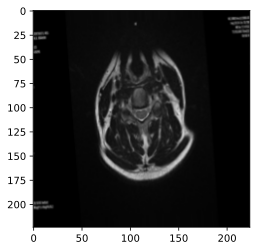

In [72]:
plt.imshow(train_mobilenetv2_data_generator[0][0][0])
plt.show()

In [73]:
train_mobilenetv2_data_generator.classes

array([0, 0, 0, ..., 2, 2, 2])

In [74]:
step_size_train=train_mobilenetv2_data_generator.n//train_mobilenetv2_data_generator.batch_size
step_size_val=test_mobilenetv2_data_generator.n//test_mobilenetv2_data_generator.batch_size
print(step_size_train)
print(step_size_val)

77
8


In [75]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=100,restore_best_weights=True, verbose = 1) 

In [76]:
history_mobilenetv2 = model.fit(train_mobilenetv2_data_generator,
                                          steps_per_epoch=step_size_train,
                                          epochs=100, 
                                          validation_data=test_mobilenetv2_data_generator,
                                          validation_steps=step_size_val,
                                          callbacks = [early_stopping]
                                         )

Epoch 1/100
77/77 [==============================] - 61s 746ms/step - loss: 0.5258 - accuracy: 0.7781 - val_loss: 0.5075 - val_accuracy: 0.8086
Epoch 2/100
77/77 [==============================] - 55s 717ms/step - loss: 0.4294 - accuracy: 0.8372 - val_loss: 0.3698 - val_accuracy: 0.8633
Epoch 3/100
77/77 [==============================] - 61s 797ms/step - loss: 0.3823 - accuracy: 0.8409 - val_loss: 0.4279 - val_accuracy: 0.8242
Epoch 4/100
77/77 [==============================] - 69s 896ms/step - loss: 0.3507 - accuracy: 0.8646 - val_loss: 0.3102 - val_accuracy: 0.8867
Epoch 5/100
77/77 [==============================] - 65s 847ms/step - loss: 0.3190 - accuracy: 0.8790 - val_loss: 0.3263 - val_accuracy: 0.8711
Epoch 6/100
77/77 [==============================] - 69s 890ms/step - loss: 0.3087 - accuracy: 0.8921 - val_loss: 0.3443 - val_accuracy: 0.8594
Epoch 7/100
77/77 [==============================] - 60s 778ms/step - loss: 0.2926 - accuracy: 0.8839 - val_loss: 0.3222 - val_accuracy:

In [77]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):    
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

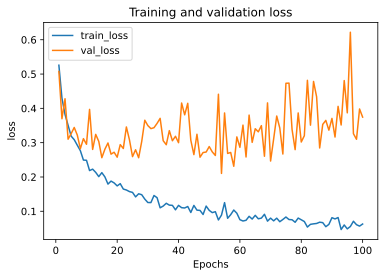

In [78]:
plot_metric(history_mobilenetv2, 'loss')

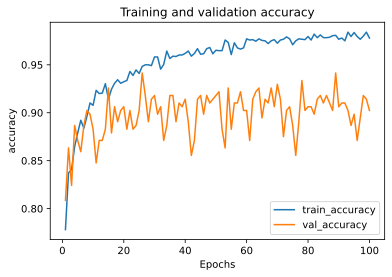

In [79]:
plot_metric(history_mobilenetv2, 'accuracy')

In [80]:
 # returns accuracy of training
print("Training Accuracy: ", history_mobilenetv2.history['accuracy'][-1])
print("Testing Accuracy : ", history_mobilenetv2.history['val_accuracy'][-1])

Training Accuracy:  0.9778506755828857
Testing Accuracy :  0.90234375


In [81]:
Y_pred = model.predict(test_mobilenetv2_data_generator, test_mobilenetv2_data_generator.n//test_mobilenetv2_data_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

9/9 [==============================] - 7s 650ms/step


array([1, 0, 0, 1, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 1,
       0, 0, 1, 0, 1, 0, 0, 2, 2, 1, 0, 1, 0, 2, 0, 0, 2, 2, 0, 1, 2, 1,
       1, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 0, 2, 2, 2, 0, 0, 1, 1, 0, 1, 1,
       0, 2, 0, 2, 1, 2, 1, 0, 0, 1, 0, 0, 0, 2, 0, 1, 2, 2, 1, 0, 1, 1,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 2, 2, 1, 1, 0,
       0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 1, 2, 2, 2, 1, 0, 1, 0, 2, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0,
       2, 0, 1, 2, 0, 2, 0, 1, 0, 2, 1, 0, 2, 1, 1, 2, 0, 2, 2, 0, 0, 0,
       2, 0, 0, 0, 1, 0, 2, 0, 2, 0, 2, 1, 2, 0, 1, 1, 0, 2, 0, 0, 2, 1,
       2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 2, 0, 0, 2, 0, 1,
       1, 2, 0, 2, 2, 1, 1, 1, 0, 0, 1, 0, 0, 2, 0, 0, 2, 1, 0, 2, 0, 2,
       1, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 1, 2, 2, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 2, 0, 1, 2, 0, 0, 2, 0, 2, 0, 0], dtype=int64)

In [82]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(test_mobilenetv2_data_generator.classes, y_pred)
target_names = ['control', 'ms', 'myelitis'] #classes names
clf_rpt = classification_report(test_mobilenetv2_data_generator.classes, y_pred, target_names=target_names)

In [83]:
conf_matrix

array([[70, 30, 38],
       [31, 15, 21],
       [34, 21, 16]], dtype=int64)

In [84]:
print(clf_rpt)

              precision    recall  f1-score   support

     control       0.52      0.51      0.51       138
          ms       0.23      0.22      0.23        67
    myelitis       0.21      0.23      0.22        71

    accuracy                           0.37       276
   macro avg       0.32      0.32      0.32       276
weighted avg       0.37      0.37      0.37       276



The Testing accuracy does seems to be good in case of rgb image prediction using mobilenetv2 when compared to CNN network.

# 3. Classification using Densnet121

#### 1. Create an instance of a mobile net pre-trained model 

In [85]:
import tensorflow_hub as hub  # tensorflow_hub is a place that contains all the pre-trained models
from keras.applications.densenet import DenseNet121

In [86]:
# base_model = MobileNetV2(weights='imagenet')
densenet_base_model=DenseNet121(include_top=False, weights='imagenet',input_shape=(224,224,3)) #imports the DenseNet121 model and discards the last neuron layer.

In [87]:
densenet_base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

Freezing the Base model layers as we want to used pretarained base model and only train the new layers on custom labels 

In [88]:
densenet_base_model.trainable = False

#### 3. Add dense layer, dropout layer, batch normalization layer on the pre-trained model
#### 4. Create a final output layer with a SoftMax activation function
#### 5. Change the batch size activation function and optimize as rmsprop and observe if the accuracy increases
#### 6. Take the loss function as categorical cross-entropy

In [89]:
penultimate_layer = base_model.layers[-1]
penultimate_layer

In [90]:
model = tf.keras.Sequential()
model.add(densenet_base_model)

# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(64 * 64 * 3)) # just an example --> choose what you want
# model.add(tf.keras.layers.Reshape((64, 64, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), strides= 2, activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128, kernel_size= (3,3), strides = 2, padding = 'same', activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(units = 128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 conv2d_6 (Conv2D)           (None, 3, 3, 64)          589888    
                                                                 
 dropout_8 (Dropout)         (None, 3, 3, 64)          0         
                                                                 
 batch_normalization_6 (Bat  (None, 3, 3, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 1, 128)        

Training only the newly added layers

In [91]:
for layer in model.layers[-12:]:
    print(layer.name, layer.output_shape)
    layer.trainable = True

conv2d_6 (None, 3, 3, 64)
dropout_8 (None, 3, 3, 64)
batch_normalization_6 (None, 3, 3, 64)
max_pooling2d_5 (None, 2, 2, 64)
conv2d_7 (None, 1, 1, 128)
dropout_9 (None, 1, 1, 128)
batch_normalization_7 (None, 1, 1, 128)
max_pooling2d_6 (None, 1, 1, 128)
flatten_2 (None, 128)
dense_5 (None, 128)
dropout_10 (None, 128)
dense_6 (None, 3)


In [92]:
model.compile(optimizer = "rmsprop" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 conv2d_6 (Conv2D)           (None, 3, 3, 64)          589888    
                                                                 
 dropout_8 (Dropout)         (None, 3, 3, 64)          0         
                                                                 
 batch_normalization_6 (Bat  (None, 3, 3, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 1, 128)        

### Getting data from folder using Imagedata generator

In [93]:
train_densnet_generator = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,     # Randomly Zoom by 20% some training images
                             rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
                             horizontal_flip = True) # Randomly flip images horizontally.

In [94]:
test_densnet_generator = ImageDataGenerator(rescale=1. / 255)

In [95]:
train_densnet_data_generator = train_densnet_generator.flow_from_directory('C:\\Users\\DELL 5540\\Desktop\Multiclass-Image-Classification-CNN\\Dataset\\train',
                                           target_size = (224, 224),
                                           batch_size = 32,     
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           shuffle=True                                           
                                          )

test_densnet_data_generator = train_densnet_generator.flow_from_directory('C:\\Users\\DELL 5540\\Desktop\Multiclass-Image-Classification-CNN\\Dataset\\test',
                                           target_size = (224, 224),
                                           batch_size = 32,     
                                           color_mode = 'rgb',
                                           class_mode = 'categorical',
                                           shuffle=True                                           
                                          )

Found 2470 images belonging to 3 classes.
Found 276 images belonging to 3 classes.


In [96]:
train_densnet_data_generator[0][0].shape

(32, 224, 224, 3)

In [97]:
train_densnet_data_generator[0][0]

array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.89496819e-02, 1.89496819e-02, 1.89496819e-02],
         [8.05682316e-03, 8.05682316e-03, 8.05682316e-03],
         [7.23688689e-04, 7.23688689e-04, 7.23688689e-04]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.72794797e-02, 1.72794797e-02, 1.72794797e-02],
         [6.87212683e-03, 6.87212683e-03, 6.87212683e-03],
         [1.94889493e-04, 1.94889493e-04, 1.94889493e-04]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.56092783e-02, 1.56092783e-02, 1.56092783e-02],
         [

In [98]:
train_densnet_data_generator[0][0][0].shape

(224, 224, 3)

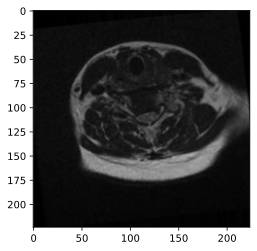

In [99]:
plt.imshow(train_densnet_data_generator[0][0][0])
plt.show()

In [100]:
train_densnet_data_generator.classes

array([0, 0, 0, ..., 2, 2, 2])

In [101]:
step_size_train=train_densnet_data_generator.n//train_densnet_data_generator.batch_size
step_size_val=test_densnet_data_generator.n//test_densnet_data_generator.batch_size
print(step_size_train)
print(step_size_val)

77
8


In [102]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=100,restore_best_weights=True, verbose = 1) 

In [103]:
history_densenet121 = model.fit(train_densnet_data_generator,
                                          steps_per_epoch=step_size_train,
                                          epochs=100, 
                                          validation_data=test_densnet_data_generator,
                                          validation_steps=step_size_val,
                                          callbacks = [early_stopping]
                                         )

Epoch 1/100
77/77 [==============================] - 183s 2s/step - loss: 0.5337 - accuracy: 0.7863 - val_loss: 0.5331 - val_accuracy: 0.7891
Epoch 2/100
77/77 [==============================] - 179s 2s/step - loss: 0.4210 - accuracy: 0.8339 - val_loss: 0.4954 - val_accuracy: 0.7969
Epoch 3/100
77/77 [==============================] - 174s 2s/step - loss: 0.3859 - accuracy: 0.8536 - val_loss: 0.5435 - val_accuracy: 0.7852
Epoch 4/100
77/77 [==============================] - 166s 2s/step - loss: 0.3764 - accuracy: 0.8556 - val_loss: 0.3923 - val_accuracy: 0.8398
Epoch 5/100
77/77 [==============================] - 167s 2s/step - loss: 0.3421 - accuracy: 0.8687 - val_loss: 0.3854 - val_accuracy: 0.8281
Epoch 6/100
77/77 [==============================] - 190s 2s/step - loss: 0.3158 - accuracy: 0.8765 - val_loss: 0.3837 - val_accuracy: 0.8398
Epoch 7/100
77/77 [==============================] - 154s 2s/step - loss: 0.2989 - accuracy: 0.8901 - val_loss: 0.3750 - val_accuracy: 0.8555
Epoch 

In [104]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):    
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

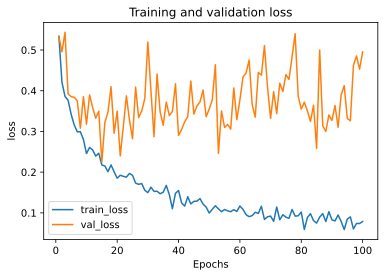

In [105]:
plot_metric(history_densenet121, 'loss')

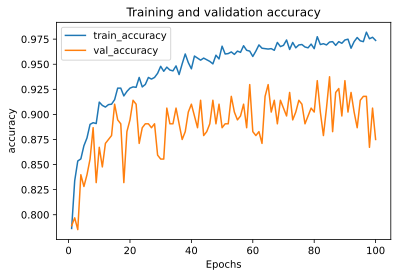

In [106]:
plot_metric(history_densenet121, 'accuracy')

In [107]:
 # returns accuracy of training
print("Training Accuracy: ", history_densenet121.history['accuracy'][-1])
print("Testing Accuracy : ", history_densenet121.history['val_accuracy'][-1])

Training Accuracy:  0.9737489819526672
Testing Accuracy :  0.875


### Testing the model

In [108]:
Y_pred = model.predict(test_densnet_data_generator, test_densnet_data_generator.n//test_densnet_data_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
y_pred

9/9 [==============================] - 19s 2s/step


array([0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 1, 1, 0, 2, 0, 1, 0,
       1, 0, 1, 1, 2, 0, 0, 2, 0, 1, 0, 2, 1, 1, 2, 2, 0, 2, 0, 2, 0, 0,
       0, 0, 1, 0, 2, 2, 1, 1, 0, 0, 1, 0, 0, 1, 2, 0, 2, 0, 2, 1, 1, 0,
       2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2,
       2, 2, 0, 1, 0, 0, 2, 0, 2, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 2, 2, 2,
       0, 1, 0, 0, 2, 0, 2, 0, 0, 1, 0, 0, 1, 1, 2, 1, 1, 0, 0, 1, 2, 0,
       1, 2, 2, 2, 0, 1, 0, 1, 2, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 1, 0, 2, 2, 1, 0, 0, 0, 0, 2,
       0, 2, 2, 0, 2, 0, 0, 2, 1, 2, 2, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0,
       0, 1, 2, 0, 1, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 2, 1, 0, 2, 1,
       1, 2, 2, 2, 0, 2, 0, 1, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0,
       2, 2, 0, 1, 0, 1, 1, 2, 0, 2, 1, 0, 0, 2, 2, 0, 1, 0, 0, 2, 0, 0,
       0, 0, 2, 0, 0, 2, 0, 1, 0, 2, 0, 2], dtype=int64)

In [109]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(test_densnet_data_generator.classes, y_pred)
target_names = ['control', 'ms', 'myelitis'] #classes names
clf_rpt = classification_report(test_densnet_data_generator.classes, y_pred, target_names=target_names)

In [110]:
conf_matrix

array([[63, 28, 47],
       [38, 10, 19],
       [36, 12, 23]], dtype=int64)

In [111]:
print(clf_rpt)

              precision    recall  f1-score   support

     control       0.46      0.46      0.46       138
          ms       0.20      0.15      0.17        67
    myelitis       0.26      0.32      0.29        71

    accuracy                           0.35       276
   macro avg       0.31      0.31      0.31       276
weighted avg       0.34      0.35      0.34       276



Classification Report

    
The classification accuracy using Densenet121 is much better then CNN and mobilenetv2. 

### Final Result: 
After comparing the results the Classification Accuracy of Densnet121 was much better then mobilenetv2 and CNN. 